In [ ]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file

sys.path.append("../../src")
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.wan_generate_video import merge_lora_weights
from musubi_tuner.utils.preproc_utils import preproc_image, preproc_mask, postproc_imgs
from musubi_tuner.utils.preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, get_all_kwargs_from_opens2v_metapath
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from musubi_tuner.utils.viz_utils import printable_metadata, return_total_visualization
from musubi_tuner.utils.bbox_utils import get_mask_from_bboxes, draw_bboxes, draw_bboxes_images, auto_scale_layout_data, get_bbox_from_mask
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout

# sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset

device = torch.device('cuda')

INFO:root:Xformers is installed!
INFO:root:Flash Attn is not installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


model_path is /u/ykwon4/models/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /u/ykwon4/models/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/u/ykwon4/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/ykwon4/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
main_path = Path("/projects/bffz/ykwon4/ComfyUI/models")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
lora_path = main_path / "loras/idmask_control_lora_wrope_v2_4-step00006000.safetensors"

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [1.0], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /projects/bffz/ykwon4/ComfyUI/models/loras/idmask_control_lora_wrope_v2_4-step00006000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.


In [5]:
vistory_dataset_path = Path('/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory')
vistory_dataset = StoryDataset(vistory_dataset_path)
main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20250927_101053/")

story_num = '02'
shot_num = 1
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)
print(prompt)

Full shot, eye level shot;Narration: David's mom always says, 'David, no!';Full view of the living room, no characters;;Daytime, living room at home, cozy but slightly messy, family photos hanging on the wall, children's books scattered on the sofa, a half-full cup of coffee on the coffee table, soft natural light filtering through the curtains;


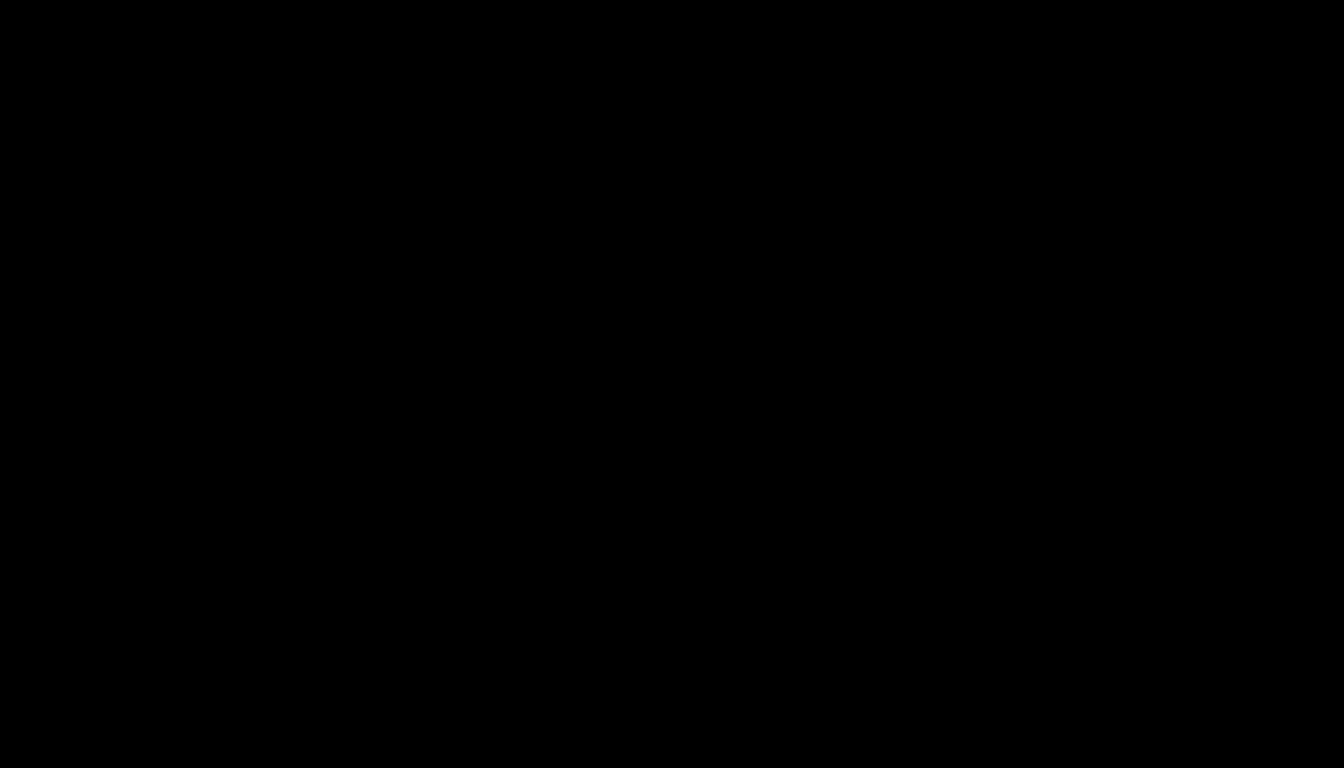

In [ ]:
width, height = 1344, 768
panel_layout = {0: {
  'bbox': [0.3, 0.2, 0.6, 0.987],
  'body': np.array([[-0.001, -0.001],
         [-0.001, -0.001],
         [ 0.411,  0.512],
         [ 0.544,  0.508]])
    }
}

# auto_scaled_layout, metadata = auto_scale_layout_data(panel_layout)
auto_scaled_layout = panel_layout
debug_dict = search_facebbox_for_layout(
    auto_scaled_layout, characters_shot, (width, height), 
    crop_face_detect=True, use_face_detect=True,
    c_width_given=None, scale_c=1.2, use_safety=True,
    bbox_mode="relative_width_full_height")

print_res = ""
for k,v in debug_dict.items():
    print_res += f"Entity {k+1} (Use Crop: {True})\n"
    print_res += f"\tControl Image Path: {v['control_image_path']}\n"
    print_res += f"\tControl Image Size: {v['control_image_size']}\n"
    print_res += "\tAttn BBox: [" + ', '.join([f"{b:.3f}" for b in v['entity_bbox']]) + "]\n"
    print_res += "\tFace BBox: [" + ', '.join([f"{b:.3f}" for b in v['face_bbox']]) + "]\n"

control_indices=[0]
latent_indices=[3]
n_chara = min(len(debug_dict), len(characters_shot), 2)
if len(debug_dict) == 0:
    control_images = []
    control_image_sizes = []
    entity_bboxes = []
    face_bboxes = []
    entity_masks = None
    debug_mask = Image.new("RGB", (width, height), (0,0,0))
else:
    control_images = [debug_dict[i]['control_image'] for i in range(n_chara)]
    control_image_sizes = [debug_dict[i]['control_image_size'] for i in range(n_chara)]
    entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(n_chara)]
    face_bboxes = [debug_dict[i]['face_bbox'] for i in range(n_chara)]
    entitymask_nps = [get_mask_from_bboxes([entity_bbox], width, height) for entity_bbox in entity_bboxes]
    entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 2)

    debug_mask = Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")
    debug_mask = draw_bboxes_images(debug_mask, face_bboxes, control_images, cimg_sizes=control_image_sizes)
    debug_mask = draw_bboxes(debug_mask, face_bboxes, width=4)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_images, entity_bboxes, width, height, vae,
    control_image_sizes,
    face_entity_bboxes=face_bboxes,
    control_indices=control_indices, latent_indices=latent_indices,
    adjust_custom_wh=False, 
    mode="provided_face_bbox",  # mode="provided_size_mid_x",
    use_rembg=False)
if len(control_nps) > 0:
    control_nps = np.concatenate([
        np.asarray(Image.fromarray(x).resize((256,256))) for x in control_nps], 
    axis=1)
else:
    control_nps = np.zeros((256,256,3), dtype=np.uint8)

print(print_res)
debug_mask

  0%|          | 0/25 [00:00<?, ?it/s]

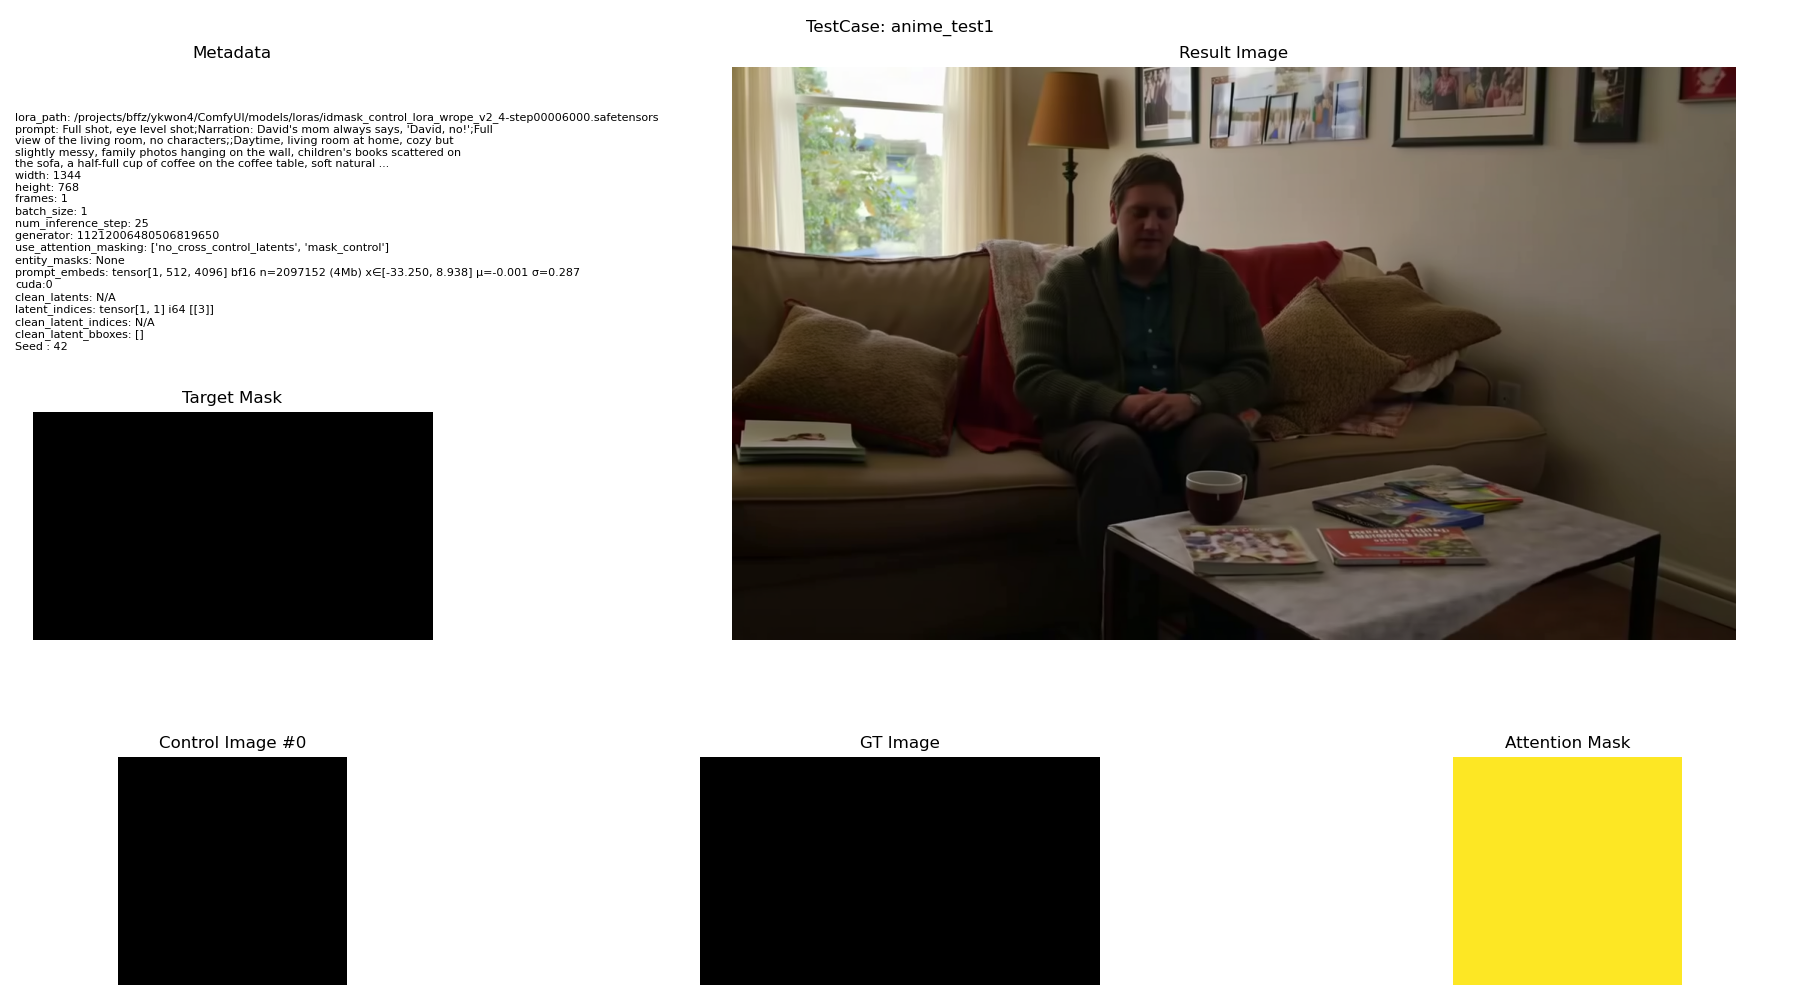

In [4]:
# seed = np.random.randint(2**31)
seed = 42
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': False, 'cache_layers': [], 
    'use_attention_masking': ['no_cross_control_latents', 'mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)
result_img = Image.fromarray(postproc_imgs(results,vae)[0])

meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80, seed=seed)
meta_str = meta_str + "\n\n" + print_res
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)

debug_img = return_total_visualization('anime_test1', meta_str, np.asarray(result_img), 
                                        attn_mask, np.asarray(control_nps), np.asarray(debug_mask), 
                                        np.zeros((height, width, 3), dtype=np.uint8))

debug_img